In [1]:
import pandas as pd
import numpy as np
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import matplotlib.pyplot as plt
import math

2023-06-26 15:40:34.882850: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# this is in utils - copying here for ease of access lol
def preprocess_conversation_columns(df):
	# remove all special characters from df
	df.columns = df.columns.str.replace('[^A-Za-z0-9_]', '', regex=True)
	
	# If data is grouped by batch/round, add a conversation num
	if {'batch_num', 'round_num'}.issubset(df.columns):
		df['conversation_num'] = df.groupby(['batch_num', 'round_num']).ngroup()
		df = df[df.columns.tolist()[-1:] + df.columns.tolist()[0:-1]] # make the new column first

	return(df)

def get_sentiment(text):

    if (pd.isnull(text)):
        return({'positive': np.nan, 'negative': np.nan, 'neutral': np.nan})
    
    encoded = tokenizer(text, return_tensors='pt')
    output = model(**encoded)

    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    # sample output format
    return({'positive': scores[2], 'negative': scores[0], 'neutral': scores[1]})

In [3]:
MODEL  = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
dataset_names = ["juries_tiny_for_testing", "jury_conversations_with_outcome_var", "csop_conversations_withblanks", "csopII_conversations_withblanks", "DAT_conversations_withblanks", "pgg_conversations_withblanks", "gurcay2015_group_estimation", "becker_group_estimation"]

directory="./data/raw_data/"

for dataset in dataset_names:
    csv_path = directory + dataset + '.csv'
    messages = pd.read_csv(csv_path, encoding='mac_roman')['message'].astype(str)
    
    sentiments = messages.apply(get_sentiment)

    sent_arr = [list(dict.values()) for dict in sentiments]

    sent_df = pd.DataFrame(sent_arr, columns =['positive_bert', 'negative_bert', 'neutral_bert']) 
    
    output_csv_folder = './sentiment_bert/'

    sent_df.to_csv(output_csv_folder + dataset + '.csv')

In [14]:
chat = pd.read_csv('./data/raw_data/juries_tiny_for_testing.csv')
pd.concat([chat,pd.read_csv('./sentiment_bert/juries_tiny_for_testing.csv').drop('Unnamed: 0', axis=1)
], axis = 1)

,batch_num,round_num,speaker_hash,speaker_nickname,timestamp,message,majority_pct,num_flipped,flipped_pct,num_votes,positive_bert,negative_bert,neutral_bert
0,0,0,5e7e1e0031f4e454e196c30b,niceRhino,2020-04-20T18:27:20.125Z,Hello!,1.0,1,0.333333,3,0.837152,0.004957,0.157891
1,0,0,5e31d6e4e31c5304c46f1413,culturedCow,2020-04-20T18:27:23.764Z,Hi!,1.0,1,0.333333,3,0.717188,0.017631,0.265181
2,0,0,5e7e4f4c31f4e454e196c9c4,spryBison,2020-04-20T18:27:27.724Z,Hello,1.0,1,0.333333,3,0.528298,0.056653,0.415048
3,0,0,5d482ea421c9be351f762255,youngLion,2020-04-20T18:27:30.410Z,Hi,1.0,1,0.333333,3,0.442517,0.093418,0.464066
4,0,0,5e84cc3c50f6e364321d6265,smallGiraffe,2020-04-20T18:27:35.506Z,hi,1.0,1,0.333333,3,0.417184,0.110424,0.472392
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0,2,5e7e4f4c31f4e454e196c9c4,newLion,2020-04-20T19:02:55.111Z,I say asshole under stress,0.6,0,0.000000,5,0.058323,0.644060,0.297617
93,0,2,5d6feec65f80ae21f5c5f054,conventionalMonkey,2020-04-20T19:03:21.819Z,"Yes, she is the asshole... unfortunately. Husb...",0.6,0,0.000000,5,0.006095,0.890461,0.103443
94,0,2,5d482ea421c9be351f762255,newPanda,2020-04-20T19:03:36.308Z,I think she is being presumptuous and acting l...,0.6,0,0.000000,5,0.007374,0.783853,0.208773
95,0,2,5e7e4f4c31f4e454e196c9c4,newLion,2020-04-20T19:03:53.219Z,"Tha's true, she ins't considering her husband ...",0.6,0,0.000000,5,0.042617,0.340634,0.616749


In [26]:
pd.DataFrame(sent_arr, columns =['positive_bert', 'negative_bert', 'neutral_bert']) 

,positive_bert,negative_bert,neutral_bert
0,0.837152,0.004957,0.157891
1,0.717188,0.017631,0.265181
2,0.528298,0.056653,0.415048
3,0.442517,0.093418,0.464066
4,0.417184,0.110424,0.472392
...,...,...,...
92,0.058323,0.644060,0.297617
93,0.006095,0.890461,0.103443
94,0.007374,0.783853,0.208773
95,0.042617,0.340634,0.616749


In [17]:
#handling due to lack of infrastructure in ipynb
# pos_ratings = sent_ratings.to_frame().rename(columns={'message':'sentiment'})
# chatted = pd.concat([chat_data, pos_ratings], axis =1)
# chatted

#parse
# column for positive_bert, neutral_bert, negative_bert, concat to the chat level output 
# generate it in another folder (bert ratings)
# concat while calculating chat level features 


NameError: name 'sent_ratings' is not defined

# Analyzing Sentiment Features Over Course of 3 Chunks

In [16]:
def get_average(chat_level_data, column_to_summarize, new_column_name):
	grouped_conversation_data = get_count_dataframe(chat_level_data, column_to_summarize)
	grouped_conversation_data[new_column_name] = grouped_conversation_data.groupby([["conversation_num", "chunk_num"]], sort=False)[column_to_summarize].transform(lambda x: np.mean(x))
	return(grouped_conversation_data[["conversation_num", "chunk_num", new_column_name]].drop_duplicates())

def get_count_dataframe(chat_level_data, on_column, speaker_id = "speaker_nickname"):
	grouped_conversation_data = chat_level_data[["conversation_num", "chunk_num", speaker_id, on_column]].groupby(["conversation_num", speaker_id]).sum().reset_index() 
    # gets this dataframe:
	# Batch# Round# Speaker  Total Number of Words
	# 0 	 1      Priya    100
	# 0      1      Yuluan   90
	return(grouped_conversation_data)

def plot_dd_results(dd_results):
	for col in dd_results:
		if (col != 'conversation_num') & (col !='chunk_num'):
			plt.figure(figsize=(12, 6))
			for conversation_num, group in dd_results.groupby('conversation_num'):
				plt.plot(group['chunk_num_plt'], group[col], label=f'Conversation {conversation_num}')

			plt.xlabel('Chunk Number (Each contains third of chats)')
			plt.ylabel(col)
			plt.title(col + ' over time')
			print(col)
			plt.show()

In [29]:
from utils.assign_chunk_nums import *
chat_data = preprocess_conversation_columns(pd.read_csv("./data/raw_data/juries_tiny_for_testing.csv"))
sentiments = pd.read_csv("./sentiment_bert/juries_tiny_for_testing.csv")
chat_data = pd.concat([chat_data, sentiments], axis = 1)
chat_data
chunked = assign_chunk_nums(chat_data, 3)

In [59]:
positive = chunked.groupby(['conversation_num', 'chunk_num']).positive_bert.apply(lambda x: np.nanmean(x))
negative = chunked.groupby(['conversation_num', 'chunk_num']).negative_bert.apply(lambda x: np.nanmean(x))
neutral = chunked.groupby(['conversation_num', 'chunk_num']).neutral_bert.apply(lambda x: np.nanmean(x))

In [60]:
pos_chunks = positive.to_frame().rename(columns={0: 'positivity_rating'})
neg_chunks = negative.to_frame().rename(columns={0: 'negativity_rating'})
neu_chunks = neutral.to_frame().rename(columns={0: 'neutrality_rating'})

neutral_bert
conversation_num chunk_num              
0                0              0.412143
                 1              0.441778
                 2              0.424859
1                0              0.456023
                 1              0.494511
                 2              0.399716

In [54]:
sentiments = pd.concat([pos_chunks, neg_chunks, neu_chunks], axis=1)
sentiments

positive_bert  negative_bert  neutral_bert
conversation_num chunk_num                                            
0                0               0.296592       0.291265      0.412143
                 1               0.148544       0.409678      0.441778
                 2               0.123821       0.451320      0.424859
1                0               0.171503       0.372474      0.456023
                 1               0.139844       0.365645      0.494511
                 2               0.092252       0.508032      0.399716

In [61]:
sentiments['chunk_num_plt'] = sentiments.groupby('conversation_num').cumcount() + 1
sentiments = sentiments.reset_index()
sentiments

,conversation_num,chunk_num,positive_bert,negative_bert,neutral_bert,chunk_num_plt
0,0,0,0.296592,0.291265,0.412143,1
1,0,1,0.148544,0.409678,0.441778,2
2,0,2,0.123821,0.451320,0.424859,3
3,1,0,0.171503,0.372474,0.456023,1
4,1,1,0.139844,0.365645,0.494511,2
5,1,2,0.092252,0.508032,0.399716,3


In [62]:
sentiments = sentiments.dropna()

In [63]:
def max_chunks_screening(df, max_chunks):
    if (len(df) == max_chunks):
        return df

new = sentiments.groupby(['conversation_num']).apply(lambda x: max_chunks_screening(x, 3))
s = new.reset_index(drop=True)
s

,conversation_num,chunk_num,positive_bert,negative_bert,neutral_bert,chunk_num_plt
0,0,0,0.296592,0.291265,0.412143,1
1,0,1,0.148544,0.409678,0.441778,2
2,0,2,0.123821,0.451320,0.424859,3
3,1,0,0.171503,0.372474,0.456023,1
4,1,1,0.139844,0.365645,0.494511,2
5,1,2,0.092252,0.508032,0.399716,3


positivity_rating


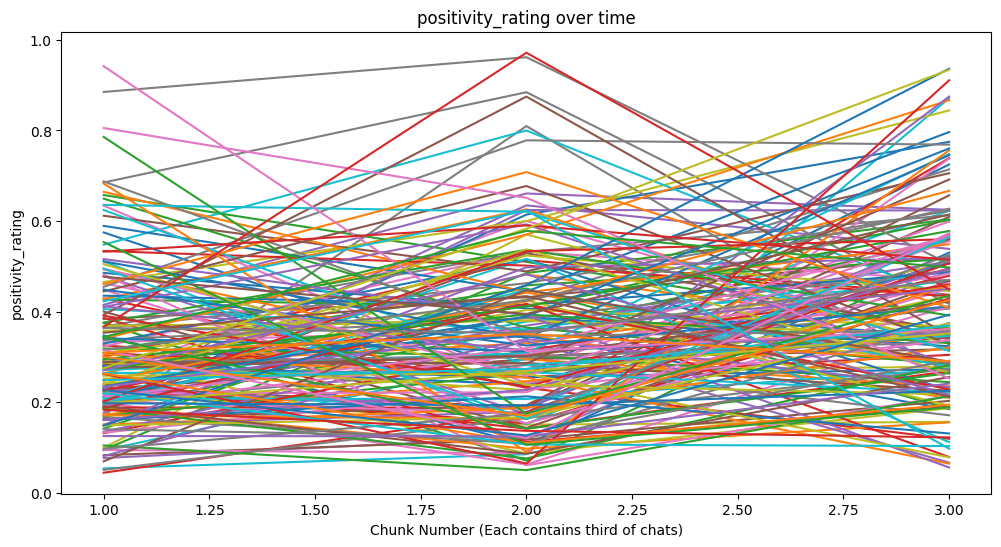

negativity_rating


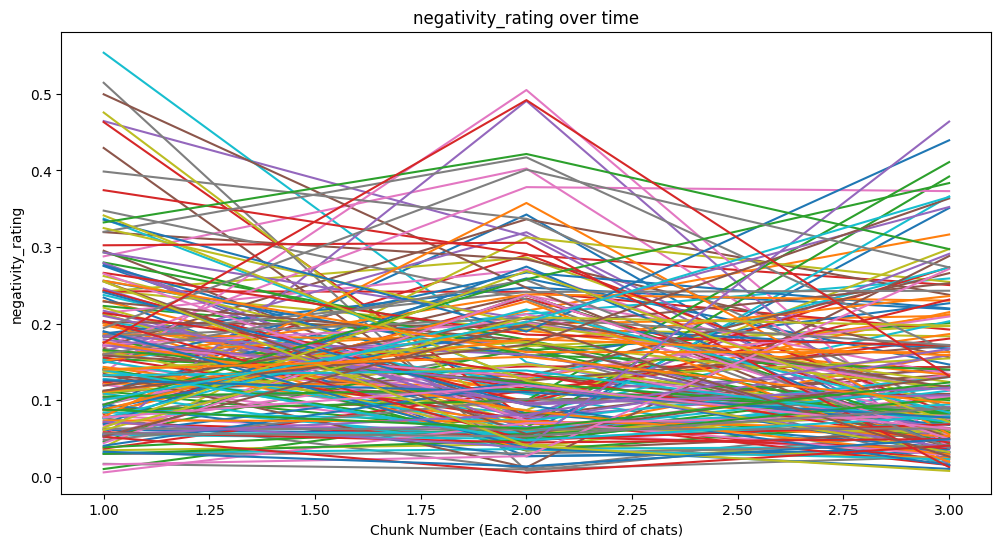

neutrality_rating


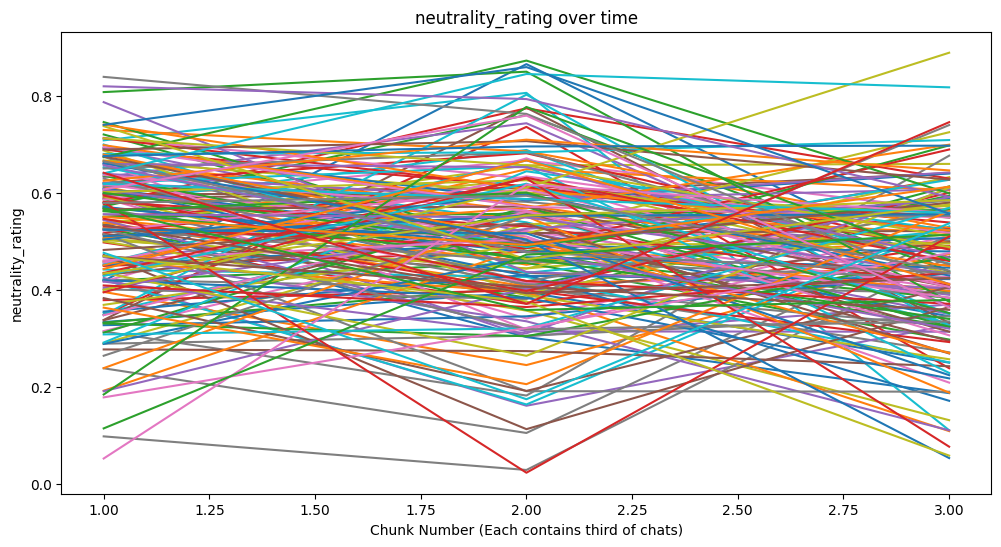

chunk_num_plt


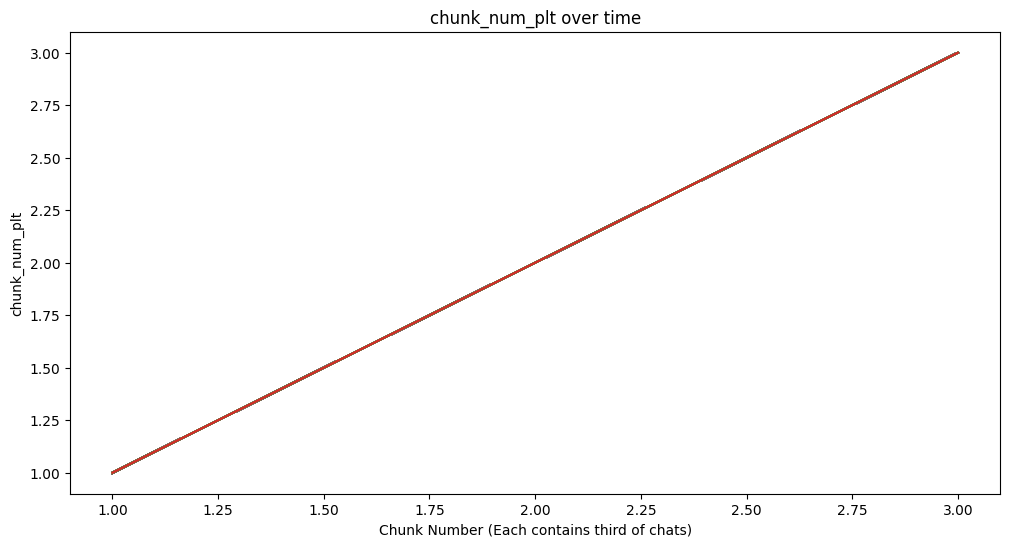

In [ ]:
plot_dd_results(s)